# Lotka Volterra

This notebook is devoted to the understanding of the PINN applied to the Lotka Volterra problem. First let's formulate the problem. The equation that describe the problem are the following:

$$
\frac{dx}{dt} = \alpha x - \beta x y
$$

$$
\frac{dy}{dt} = \delta x y - \gamma y
$$

Let's suppose to fix the value of the parameters to:
$$
\alpha = 0.25 \\
\beta = 0.0 \\
\gamma = 2 \\
\delta = 0.25 \\
$$


Following what we did in the first_example notebook, let's first define the Neural_net. The strcture is really similar to the one of the first example, with the only addition of some layers, in order to make the network deeper. 

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

class Neural_net(torch.nn.Module):
    def __init__(self, n_in = 1, n_out =1):
        super(Neural_net, self).__init__()

        self.tanh = torch.nn.Tanh()

        self.layer1 = torch.nn.Linear(n_in,20)
        self.layer2 = torch.nn.Linear(20,20)
        self.layer3 = torch.nn.Linear(20,20)
        self.layer_out = torch.nn.Linear(20,n_out)

    def forward(self, x):
        x = self.layer1(x)
        x = self.tanh(x)
        x = self.layer2(x)
        x = self.tanh(x)
        x = self.layer3(x)
        x = self.tanh(x)
        x = self.layer_out(x)

        return x

As befone, let's create a class of the PINN model, where we define the wrap_grad, used to computer the derivative of `f` with respect to `x`. 

In [2]:
class predprey_pinn():
    def wrap_grad(self, f,x):
        return torch.autograd.grad(f,x,
        grad_outputs=torch.ones_like(x),
        retain_graph=True,
        create_graph=True)[0]
 

Let's define the normalization data. The normalization is done in a really simple way. Given the un-normalized tensor `unnormed`, the minimum of of all values is subtracted. Then, the resulting value is divided by the difference of the maximum and minimum value, that is like a range. This is used to make the value more consistent as well as the neural network training. 

On the other side, the `un_normalize` function is used to un-normalize the data. It does exactly the opposite process.

In [3]:
class predprey_pinn(predprey_pinn):
    def normalize(self, id, unnormed):
        return (unnormed - self.mins[id])/(self.maxes[id]- self.mins[id])

    def un_normalize(self, id, normed):
        return normed*(self.maxes[id] -self.mins[id])+ self.mins[id]

Let's now define the loss. The logic behind the loss is exactly the same as the one already used in the first example. First we extrapolate `x`and `y` from the output of the model. Then we differentiate them with the `wrap_grad` method. 
Then, it's as easy as computing `ls0` and `ls1` following the equations previously defined. The last contribute of the loss is the one caused by the initial condition, which is `ic`. The total loss is the sum of these 3 contributions.

The other important loss is the data loss. This is computed by the function `data_loss`. It is a really simple squared difference between the output of the model and the normalized values. It is done for both `x`and `y` and then the two contribution are sumed. 

Finally, the `combine_loss` function just sums the two loss contribution. 

In [4]:
class predprey_pinn(predprey_pinn):
    def de_loss(self):
        pred = self.model(self.domain)
        x,y = (d.reshape(-1,1) for d in torch.unbind(pred, dim =1))
        
        dx = self.wrap_grad(x, self.domain)
        dy = self.wrap_grad(y, self.domain)

        x = self.un_normalize(0,x)
        y = self.un_normalize(1,y)

        ls0 = torch.mean((dx - (self.alpha*x -self.beta*x*y)/(self.maxes[0]-self.mins[0]) )**2)
        ls1 = torch.mean((dy -(self.delta*x*y - y*self.gamma)/(self.maxes[1]-self.mins[1]))**2)
        ic = torch.mean((self.c0-pred[0])**2)
        
        return ls0 + ls1 + ic
    
    def data_loss(self):
        x,y = torch.unbind(self.model(self.t_dat), dim = 1)
        z1 = torch.mean((x - self.x_norm)**2)
        z2 = torch.mean((y- self.y_norm)**2)
        return z1 + z2
    
    def combined_loss(self):
        return self.de_loss() + self.data_loss()


Now, let's define the `__init__` method of the class `predprey_pinn`. In this function, we initialize all the model parameters, as well as preparing the data. In addition to that, two types of optimizer are defined, ADAM and LBFGS. 

In [5]:
class predprey_pinn(predprey_pinn): 
    def __init__(self, epochs, data, c0):
        self.epochs = epochs
        self.model = Neural_net(n_out=2)
        self.domain = torch.linspace(0,int(max(data[0])),100, requires_grad=True).reshape(-1,1)

        self.lbfgs_optimizer = torch.optim.LBFGS(params = self.model.parameters(), lr = 0.001,max_iter = 500)
        self.adam_optimizer = torch.optim.Adam(params = self.model.parameters(), lr = 0.0001)

        self.alpha = 0.25
        self.beta = 0.02
        self.delta = 0.25
        self.gamma = 2

        self.t_dat = torch.tensor(data[0], dtype=torch.float).reshape(-1,1)
        self.x_dat = torch.tensor(data[1],dtype=torch.float)
        self.y_dat = torch.tensor(data[2], dtype=torch.float )

        self.maxes = {}
        self.mins = {}

        for id,d in enumerate((self.x_dat, self.y_dat)):
            self.maxes[id] = max(d)
            self.mins[id] = min(d)

        self.x_norm = self.normalize(0, self.x_dat)
        self.y_norm = self.normalize(1, self.y_dat)

        x0 = self.normalize(0,c0[0])
        y0 = self.normalize(1,c0[1])
        self.c0 = torch.tensor([x0,y0], dtype = torch.float)


Let's add some other utility function, such as the plot and the training loops with the two different optimizers.

In [6]:
class predprey_pinn(predprey_pinn):
    def plot_preds(self):
        x,y = torch.unbind(self.model(self.domain), dim = 1)
        x = self.un_normalize(0,x)
        y = self.un_normalize(1,y)
        plt.plot(self.domain.detach(), x.detach(), label = 'x pred')
        plt.plot(self.domain.detach(), y.detach(), label = 'y pred')

        plt.scatter(self.t_dat.detach(), self.x_dat, label = 'x data')
        plt.scatter(self.t_dat.detach(),self.y_dat, label = 'y data' )
        plt.legend()
        
    def lbfgs_train(self):
        self.model.train()    
        for epoch in range(self.epochs):
            def closure():
                self.lbfgs_optimizer.zero_grad()
                loss = self.combined_loss()
                loss.backward()
                return loss
            self.lbfgs_optimizer.step(closure=closure)
            print(f'Epoch {epoch}, loss: {self.combined_loss()}, beta_param: {self.beta}, gamma_param: {self.gamma}')
        self.plot_preds()
            
        

    def adam_train(self):
        steps = 1000
        self.model.train()
        for epoch in range(self.epochs):
            for step in range(steps):
                def closure():
                    self.adam_optimizer.zero_grad()
                    loss = self.combined_loss()
                    loss.backward()
                    return loss
                self.adam_optimizer.step(closure=closure)
            print(f'Epoch {epoch}, loss: {self.combined_loss()}, beta_param: {self.beta}, gamma_param: {self.gamma}')
        self.plot_preds()

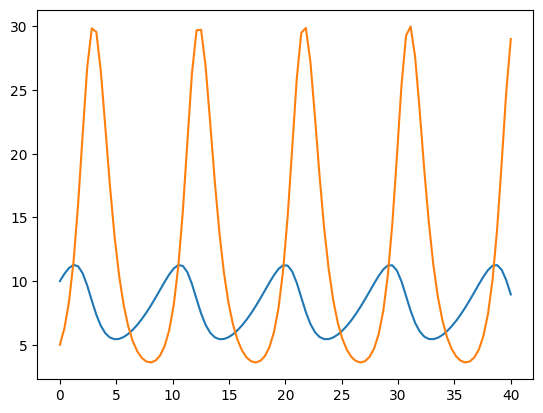

In [7]:
alpha = 0.25
beta = 0.02
delta = 0.25
gamma = 2


def pp_ode(state, t):
    x,y = state
    dx = alpha*x -beta*x*y
    dy = delta*x*y - y*gamma
    return [dx, dy]

t = np.linspace(0,40,100)
sol = odeint(pp_ode,y0 =[10,5], t=t)

plt.plot(t, sol[:,0])
plt.plot(t, sol[:,1])

inp_dat = np.array([t, sol[:,0], sol[:,1]])

In [12]:
test_inst = predprey_pinn(epochs=100, data= inp_dat, c0 =[10,5])

In [13]:
inp_dat.shape

(3, 100)

Epoch 0, loss: 0.23308014869689941, beta_param: 0.02, gamma_param: 2
Epoch 1, loss: 0.22345496714115143, beta_param: 0.02, gamma_param: 2
Epoch 2, loss: 0.2165164202451706, beta_param: 0.02, gamma_param: 2
Epoch 3, loss: 0.21012863516807556, beta_param: 0.02, gamma_param: 2
Epoch 4, loss: 0.20263156294822693, beta_param: 0.02, gamma_param: 2
Epoch 5, loss: 0.1971396952867508, beta_param: 0.02, gamma_param: 2
Epoch 6, loss: 0.1942151039838791, beta_param: 0.02, gamma_param: 2
Epoch 7, loss: 0.1920648217201233, beta_param: 0.02, gamma_param: 2
Epoch 8, loss: 0.18921177089214325, beta_param: 0.02, gamma_param: 2
Epoch 9, loss: 0.18767774105072021, beta_param: 0.02, gamma_param: 2
Epoch 10, loss: 0.18651695549488068, beta_param: 0.02, gamma_param: 2
Epoch 11, loss: 0.1851087063550949, beta_param: 0.02, gamma_param: 2
Epoch 12, loss: 0.1823587864637375, beta_param: 0.02, gamma_param: 2
Epoch 13, loss: 0.17489364743232727, beta_param: 0.02, gamma_param: 2
Epoch 14, loss: 0.16723360121250153,

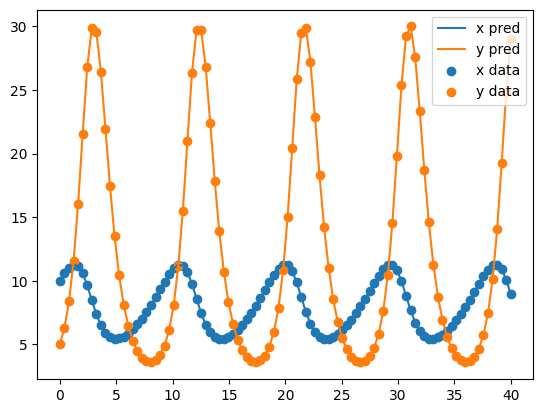

In [14]:
test_inst.adam_train()